<a href="https://colab.research.google.com/github/twestonGOS/twestonGOS/blob/main/AHP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook to compute AHP weights for technology priorities

Updated: 23/5/22

In [ ]:
import pandas as pd
import numpy as np
import json

Install Library to compute AHP weights:

In [ ]:
!pip install pyahp
!pip3 install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#module to compute priorities from a comparison matrix
def manual_priorities(matrix):
  #using method described here https://core.ac.uk/download/pdf/29582997.pdf that assumes a 'consistent' matrix (lower triangle=reciprocal of upper)
  normalised_matrix=matrix/matrix.sum(axis=0) 
  return normalised_matrix.sum(axis=1)/normalised_matrix.shape[1] 

In [ ]:
from pyahp import parse

Now read in Tech comparison data structure from Kumu spreadsheet

In [ ]:
kmu=pd.read_excel('/content/Kumu240522.xlsx',sheet_name='Element Cap')

In [ ]:
kmu_array_inplay_caps=pd.DataFrame.to_numpy(kmu)

In [ ]:
kmu=pd.read_excel('/content/Kumu240522.xlsx',sheet_name='Element L1')

In [ ]:
kmu_array_inplay_L1=pd.DataFrame.to_numpy(kmu)

Select those capabilities and technologies that are being investigated (i.e. in-play)

In [ ]:
kmu_array_inplay_caps=kmu_array_inplay_caps[np.where(kmu_array_inplay_caps[:,2]=='Prioritised')] #filter out tag=2, which means entities that are to be compared

In [ ]:
kmu_array_inplay_L1=kmu_array_inplay_L1[np.where(kmu_array_inplay_L1[:,2]=='Prioritised')] #filter out tag=2, which means entities that are to be compared

Read in sheet that encodes the Cap-App-Tech links

In [ ]:
kmu_links_Cap_App=pd.read_excel('/content/Kumu240522.xlsx',sheet_name='Connection Cap to App')

In [ ]:
kmu_links_Cap_App_array=pd.DataFrame.to_numpy(kmu_links_Cap_App)

In [ ]:
kmu_links_App_L1=pd.read_excel('/content/Kumu240522.xlsx',sheet_name='Connection App to L1')

In [ ]:
kmu_links_App_L1_array=pd.DataFrame.to_numpy(kmu_links_App_L1)

Start to construct the model 

In [ ]:
criteria=["Criteria1","Criteria2","Criteria3","Criteria4","Criteria5"] #five criteria 
#criteria=["crit1","crit2"] #reduce number for testing if required

In [ ]:
subcriteria_crit1=kmu_array_inplay_caps
#subcriteria_crit1=subcriteria_crit1[0:2,:] #reduce number for testing if required
print(subcriteria_crit1[:,0])

['Long-term energy storage' 'Space and water heating'
 'Data processing and simulation' 'Clean secure dispatchable electricity'
 'GHG removal' 'System integration and optimisation' '5R'
 'Charging/Fueling infrastructure' 'Renewable energy distribution'
 'Maximise farm yield']


In [ ]:
alternatives=kmu_array_inplay_L1
#alternatives=alternatives[0:2,:] #reduce number for testing if required
print(alternatives[:,0])

['Semiconductors\u200b' 'Novel Batteries'
 'Renewable energy generation technologies\u200b'
 'Big Data Infrastructure' 'CCUS' 'Nuclear Fusion' 'Nuclear Fission'
 'Advanced computing\u200b' 'Computer-mediated reality\u200b'
 'Quantum technologies' 'Machine Learning\u200b' 'Future Telecoms\u200b'
 'Photonics\u200b' 'Sensors' 'Engineering biology' 'Satellites\u200b'
 'Drones\u200b' 'Omics (L1)' 'Advanced robotics\u200b'
 'Additive Manufacturing\u200b' 'Advanced Materials\u200b']


In [ ]:
print('Model contains:')
print(len(criteria),'criteria')
print(len(subcriteria_crit1),'capabilities (subcriteria under criterion 1)')
print(len(alternatives),'level-1 tech')
ncrit=len(criteria)
ncap=len(subcriteria_crit1)
ntech=len(alternatives)

Model contains:
5 criteria
10 capabilities (subcriteria under criterion 1)
21 level-1 tech


Create Mapping from Cap to Tech 

In [ ]:
Cap_Tech_Matrix=np.ones([ncap,ntech])
for i in range(ncap):
  Cap=subcriteria_crit1[i,0]
  Apps=np.squeeze(kmu_links_Cap_App_array[np.where(kmu_links_Cap_App_array[:,0]==Cap),1])
  for j in range(0,len(Apps)):
    Techs=np.squeeze(kmu_links_App_L1_array[np.where(kmu_links_App_L1_array[:,0]==Apps[j]),1])
    for k in range(ntech):
      if np.isin(alternatives[k,0],Techs)==True:
        Cap_Tech_Matrix[i,k]=9

Read in Cap Weighting

In [ ]:
cap_weight=pd.read_excel('/content/Caps_Crit1.xlsx')

In [ ]:
cap_weight_array=pd.DataFrame.to_numpy(cap_weight)

In [ ]:
capweights=np.zeros(ncap)
for i in range(ncap):
  capweights[i]=cap_weight_array[np.where(cap_weight_array[:,0]==subcriteria_crit1[i,0]),1]

In [ ]:
capweights=1.+(capweights-np.min(capweights))*(9.-1.)/(np.max(capweights)-np.min(capweights)) #re-normalise for AHP

Start to construct thee input dictionary 

In [ ]:
d = {"name": "Tech Comparison","method": "approximate","criteria":criteria}

add subcriteria for criterion 1

In [ ]:
dsubsub={"Criteria1": np.ndarray.tolist(subcriteria_crit1[:,0])}
dsub={"subCriteria":dsubsub}

In [ ]:
d.update(dsub)

In [ ]:
d #print the dictionary (can also do this later, but it gets very long!)

{'criteria': ['Criteria1', 'Criteria2', 'Criteria3', 'Criteria4', 'Criteria5'],
 'method': 'approximate',
 'name': 'Tech Comparison',
 'subCriteria': {'Criteria1': ['Long-term energy storage',
   'Space and water heating',
   'Data processing and simulation',
   'Clean secure dispatchable electricity',
   'GHG removal',
   'System integration and optimisation',
   '5R',
   'Charging/Fueling infrastructure',
   'Renewable energy distribution',
   'Maximise farm yield']}}

Add alternatives (final tech layer)

In [ ]:
d.update({"alternatives":np.ndarray.tolist(alternatives[:,0])})

Create the pairwise matrices (initalised as unity) for all combinations in the hierarchy 

In [ ]:
tech_priors=np.zeros([ntech,ncrit])

In [ ]:
#comparison of: criteria wrt objective
critmatrix=np.ones([ncrit,ncrit])
criteria_matrix_dict={"criteria":np.ndarray.tolist(critmatrix)}
crit_priors=manual_priorities(critmatrix)

In [ ]:
#comparison of: subcriteria for criterion 1 (capabilities) wrt criterion 1
capmatrix=np.ones([ncap,ncap])
for j in range(ncap):
  for k in range(ncap):
    capmatrix[j,k]=capweights[k]/capweights[j] #use cap weights read in to create comparison matrix
subCriteria_crit1_matrix_dict={"subCriteria:crit1":np.ndarray.tolist(capmatrix)}
criteria_matrix_dict.update(subCriteria_crit1_matrix_dict)
cap_priors=manual_priorities(capmatrix)

In [ ]:
#comparison of: alternatives (Level 1) wrt subcriteria for criterion 1 (capabilities)
tech_priors_1=np.zeros([ntech,ncap])
for i in range(len(subcriteria_crit1[:,0])):
  instring="alternatives:"+subcriteria_crit1[i,0]
  techmatrix=np.ones([ntech,ntech])
  for j in range(ntech):
    for k in range(ntech):
      techmatrix[j,k]=Cap_Tech_Matrix[i,j]/Cap_Tech_Matrix[i,k] #create comparison matrix using derived links  
  alternative_subCriteria_crit1_matrix_dict={instring:np.ndarray.tolist(techmatrix)}
  criteria_matrix_dict.update(alternative_subCriteria_crit1_matrix_dict)
  tech_priors_1[:,i]=manual_priorities(techmatrix)

In [ ]:
for i in range(ntech):
  tech_priors[i,0]=0
  for j in range(ncap):
    tech_priors[i,0]+=tech_priors_1[i,j]*cap_priors[j]

In [ ]:
#comparison of: alternatives (Level 1) wrt criteria 2-5
for i in range(1,len(criteria)):
  instring="alternatives:"+criteria[i]
  techmatrix=np.ones([ntech,ntech])
  for j in range(ntech):
    for k in range(ntech):
      techmatrix[j,k]=1. #initialise to unity (equal importance)
  alternative_crit_matrix_dict={instring:np.ndarray.tolist(techmatrix)}
  criteria_matrix_dict.update(alternative_crit_matrix_dict)
  tech_priors[:,i]=manual_priorities(techmatrix)

In [ ]:
priors=np.zeros([ntech])
for i in range(ntech):
  for j in range(ncrit):
    priors[i]+=tech_priors[i,j]*crit_priors[j]

In [ ]:
priors_per_crit=np.zeros([ntech,ncrit])
for i in range(ntech):
  for j in range(ncrit):
    priors_per_crit[i,j]=tech_priors[i,j]*crit_priors[j]

In [ ]:
preferenceMatrices_dict={"preferenceMatrices":criteria_matrix_dict}

In [ ]:
d.update(preferenceMatrices_dict)

Now do the AHP (only need to do if you want to validate the manual computation of of the AHP weights)

In [ ]:
#ahp_model = parse(d) #build model and check for consistency 

In [ ]:
#priorities = ahp_model.get_priorities() #calculate priorities (sum to unit)

Print Results

In [ ]:
print('Level 1 Tech','|','Relative Importance Weight')
print('')
for i in range(len(alternatives)):
  print('%s, %.3f'%(alternatives[i,0],priors[i]/(1/ntech)))

Level 1 Tech | Relative Importance Weight

Semiconductors​, 1.143
Novel Batteries, 1.027
Renewable energy generation technologies​, 1.056
Big Data Infrastructure, 1.071
CCUS, 1.140
Nuclear Fusion, 0.851
Nuclear Fission, 0.978
Advanced computing​, 1.045
Computer-mediated reality​, 0.985
Quantum technologies, 1.014
Machine Learning​, 1.045
Future Telecoms​, 1.001
Photonics​, 0.970
Sensors, 0.946
Engineering biology, 1.016
Satellites​, 0.941
Drones​, 0.918
Omics (L1), 1.016
Advanced robotics​, 0.924
Additive Manufacturing​, 0.901
Advanced Materials​, 1.014


Print ranking based on AHP weights

In [ ]:
from scipy.stats import rankdata

In [ ]:
rank=np.argsort(priors/(1/ntech))[::-1]

In [ ]:
priorities_float = priors

In [ ]:
print('Level 1 Tech','|','Relative Importance Weight (sum to 1, or sum to number of tech)')
print('')
for i in range(len(alternatives)):
  print('%s, %.3f'%(alternatives[rank[i],0],priors[rank[i]]/(1/ntech)))

Level 1 Tech | Relative Importance Weight (sum to 1, or sum to number of tech)

Semiconductors​, 1.143
CCUS, 1.140
Big Data Infrastructure, 1.071
Renewable energy generation technologies​, 1.056
Advanced computing​, 1.045
Machine Learning​, 1.045
Novel Batteries, 1.027
Engineering biology, 1.016
Omics (L1), 1.016
Quantum technologies, 1.014
Advanced Materials​, 1.014
Future Telecoms​, 1.001
Computer-mediated reality​, 0.985
Nuclear Fission, 0.978
Photonics​, 0.970
Sensors, 0.946
Satellites​, 0.941
Advanced robotics​, 0.924
Drones​, 0.918
Additive Manufacturing​, 0.901
Nuclear Fusion, 0.851


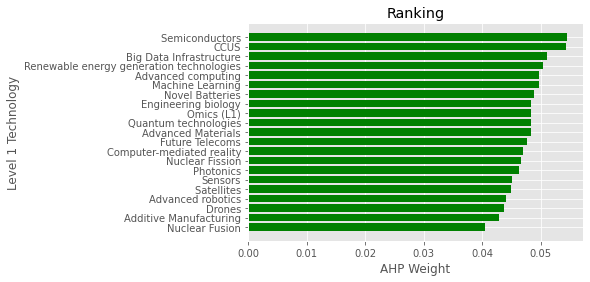

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x=alternatives[rank,0]
y = priorities_float[rank]

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, y, color='green')
plt.ylabel("Level 1 Technology")
plt.xlabel("AHP Weight")

plt.yticks(x_pos, x)
plt.gca().invert_yaxis()
plt.title("Ranking")


plt.show()

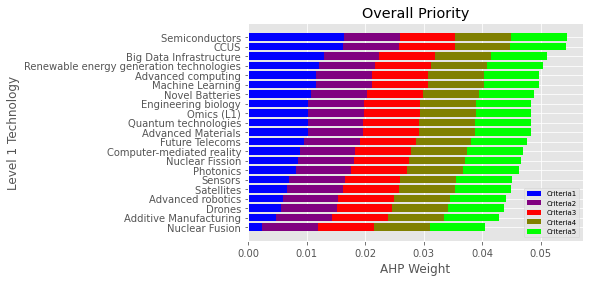

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

labels = alternatives[rank,0]
width = 0.8     # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

cmap = cm.get_cmap('brg', ncrit)
inner_colors = cmap(np.arange(ncrit))#['r','g','b','m','c']

psum=np.zeros([ntech])
ax.barh(labels, priors_per_crit[rank,0], width, label=criteria[0],color=inner_colors[0])
psum=priors_per_crit[rank,0]
for i in range(1,ncrit):
  ax.barh(labels, priors_per_crit[rank,i], width, label=criteria[i],left=psum,color=inner_colors[i])
  psum+=priors_per_crit[rank,i]

ax.legend(fontsize=7.)
ax.invert_yaxis()

plt.ylabel("Level 1 Technology")
plt.xlabel("AHP Weight")
plt.title("Overall Priority")
plt.savefig('Overall.png',bbox_inches='tight')
plt.show()

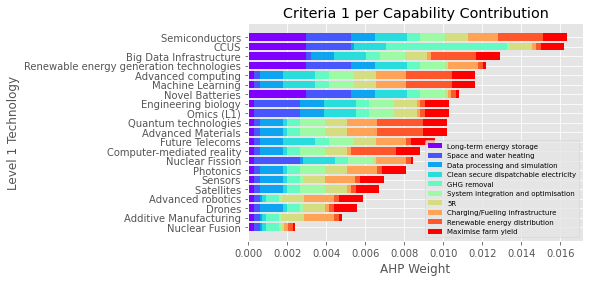

In [ ]:
labels = alternatives[rank,0]
width = 0.8     # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

cmap = cm.get_cmap('rainbow', ncap)
inner_colors = cmap(np.arange(ncap))

psum=np.zeros([ntech])
ax.barh(labels, tech_priors_1[rank,0]*cap_priors[0]*crit_priors[0], width, label=subcriteria_crit1[0,0],color=inner_colors[0])
psum=tech_priors_1[rank,0]*cap_priors[0]*crit_priors[0]
for i in range(1,ncap):
  ax.barh(labels, tech_priors_1[rank,i]*cap_priors[i]*crit_priors[0], width, label=subcriteria_crit1[i,0],left=psum,color=inner_colors[i])
  psum+=tech_priors_1[rank,i]*cap_priors[i]*crit_priors[0]

ax.legend(fontsize=7.)
ax.invert_yaxis()

plt.ylabel("Level 1 Technology")
plt.xlabel("AHP Weight")
plt.title("Criteria 1 per Capability Contribution")
plt.savefig('Cap.png',bbox_inches='tight')
plt.show()

Draw Hierarchy

In [ ]:
altdict={}
for i in range(3): #limit to a small number (can show all if one wants), by setting max to ntech
  altdict.update([(i,alternatives[i,0])])
altdict.update([(i,'...')])

In [ ]:
sh={subcriteria_crit1[0,0]:altdict}
for i in range(1,3): #limit to a small number (can show all if one wants), by setting max to ncap
  sh.update({subcriteria_crit1[i,0]:altdict})
sh.update({'..':altdict})

In [ ]:
critdict={criteria[0]:sh}
for i in range(1,ncrit):
  critdict.update({criteria[i]:altdict})

In [ ]:
h={'Sustainability':critdict}

In [ ]:
def draw(parent_name, child_name):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)

def visit(node, parent=None):
    for k,v in node.items():
        if isinstance(v, dict):
            # We start with the root node whose parent is None
            # we don't want to graph the None node
            if parent:
                draw(parent, k)
            visit(v, k)
        else:
            draw(parent, v)

In [ ]:
import pydot 
graph = pydot.Dot(graph_type='graph')
visit(h)
graph.write_png('example1_graph.png')

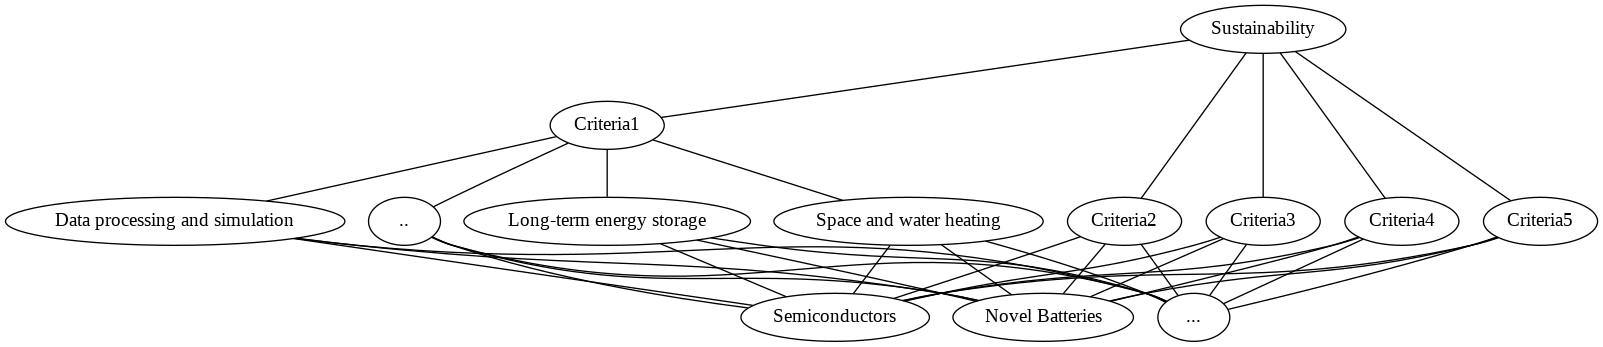

In [ ]:
from IPython.display import Image
Image(filename='example1_graph.png') 

Make a force directed network 

In [ ]:
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyvis: filename=pyvis-0.2.1-py3-none-any.whl size=23688 sha256=38d67250bf82a350f3357ae9fbabfb1aa736575392e4ca92320887c7f3fae55c
  Stored in directory: /root/.cache/pip/wheels/2a/8f/04/6340d46afc74f59cc857a594ca1a2a14a1f4cbd4fd6c2e9306
Successfully built pyvis


In [ ]:
from pyvis.network import Network

cmap = cm.get_cmap('rainbow', ncap)
inner_colors = cmap(np.arange(ncap))

net = Network(layout=True,height="500px",width="500px")

net.add_node(9999, label="Sustainability",level=0,shape='box') 

for i in range(ntech):
  net.add_node(i, label=alternatives[i,0],level=3,shape='box') 

net.add_node(1000, label=criteria[0],level=1,shape='box') 
net.add_edge(9999, 1000, weight=.87)
for i in range(ncap):
  net.add_node(ntech+1+i, label=subcriteria_crit1[i,0],level=2,shape='box') # node id and label = 2
  net.add_edge(ntech+1+i, 1000, value=cap_priors[i])
  for j in range(ntech):
    if Cap_Tech_Matrix[i,j]==1:
      weight=tech_priors_1[j,i]*cap_priors[i]
      net.add_edge(ntech+1+i, j, value=weight)

for i in range(1,ncrit):
  net.add_node(1000*(i+1),label=criteria[i],level=1,shape='box')
  net.add_edge(9999, 1000*(i+1), weight=.87)
  for j in range(ntech):
    net.add_edge(1000*(i+1), j, weight=.87)

#net.toggle_physics(False)
net.save_graph('/content/mygraph.html')

In [ ]:
from IPython.display import HTML
HTML(filename='/content/mygraph.html')

End of Notebook